In [158]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from tqdm import tqdm
import itertools
import random
#import warnings
#warnings.filterwarnings('ignore')
#from pyeasyga import pyeasyga

In [159]:
def hill_activation(x, K, n, ymin, ymax):
    return  ymin + (ymax - ymin) * (x**n / (K**n + x**n))

def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2):
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1, ymax1) * hill_activation(x2, K2, n2, ymin2, ymax2)

In [231]:
fluos = pd.read_csv('datasets/induction_matrix_and/induction_fluos.csv', index_col='time')
ods = pd.read_csv('datasets/induction_matrix_and/induction_ods.csv', index_col='time')
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']#, 'e16x30SspGyrB', 'e32x33NrdJ1']
controls = ['positive_control', 'negative_control']

In [228]:
#both latest ara and cuma data
hill_params = {'e11x32STPhoRadA': [1.38609966e-02, 1.60895892e+02, 4.00000000e+00, 7.77066640e-01,
        8.47975638e-38, 1.40958159e-04, 6.03613733e+00, 6.03613733e+00],
 'e15x32NpuSspS2': [2.51938785e-02, 7.73416012e+00, 1.39580084e+00, 3.28358067e+00,
        1.21508540e-03, 1.21508540e-03, 1.08890566e+00, 1.08890566e+00],
 'e16x33NrdA2': [2.95748723e-02, 2.41023864e+01, 2.20839441e+00, 2.05342677e+00,
        1.03610762e-03, 1.03610762e-03, 6.61478933e+00, 6.61478933e+00],
 'e20x32gp411': [4.92310594e-02, 1.37152945e+00, 1.43643677e+00, 1.37682288e+00,
        2.13397217e-39, 5.50018830e-03, 2.83428427e+00, 1.08094260e+00],
 'e32x30SspGyrB': [3.74641327e-02, 1.77964343e+01, 1.45395085e+00, 2.84911799e+00,
        1.20825150e-03, 1.03106627e-02, 6.18377096e+00, 6.18377096e+00],
 'e34x30MjaKlbA': [1.67520247e-02, 1.20550643e+01, 1.64259675e+00, 4.00000000e+00,
        1.17478406e-02, 1.01340517e-28, 3.24902918e+00, 3.24902918e+00],
 'e38x32gp418': [0.01584764, 7.74578092, 2.11549538, 0.94039094, 0.01206151,
        0.01091636, 1.15701608, 2.30753701],
 'e41x32NrdJ1': [2.58223826e-02, 1.21469529e+01, 1.80960540e+00, 4.00000000e+00,
        8.69390911e-03, 8.69390911e-03, 3.52150568e+00, 3.52150568e+00],
 'e42x32STIMPDH1': [3.59706447e-02, 1.52777618e+01, 1.75790925e+00, 1.73524502e+00,
        4.35999152e-33, 2.97909555e-03, 2.34091743e+00, 2.34091743e+00]
}

In [5]:
hill_params = {'e11x32STPhoRadA': [2.36766927e-02, 1.00000000e+03, 4.00000000e+00, 1.44153218e-01,
        4.85020662e-35, 1.05460242e-03, 6.03613733e+00, 1.56850653e+00],
 'e15x32NpuSspS2': [2.92755784e-02, 9.56644812e+00, 3.19925784e+00, 4.73602217e-01,
        6.43583962e-15, 1.21508540e-03, 1.08890566e+00, 1.08890566e+00],
 'e16x33NrdA2': [3.13214865e-02, 1.00000000e+03, 4.00000000e+00, 3.26516831e-01,
        6.00075781e-39, 1.03610762e-03, 6.61478933e+00, 3.36137478e+00],
 'e20x32gp411': [3.87095907e-02, 2.87402515e-02, 3.21473595e+00, 1.10916549e+00,
        5.89561838e-35, 5.50018830e-03, 4.29512074e+00, 6.08724702e-01],
 'e32x30SspGyrB': [3.38882129e-02, 1.00000000e+03, 3.54036286e+00, 4.31880965e-01,
        2.64511978e-37, 1.03106627e-02, 6.18377096e+00, 4.42459651e+00],
 'e34x30MjaKlbA': [2.49883923e-02, 3.19177623e+01, 4.00000000e+00, 1.44104721e+00,
        1.20619143e-33, 1.17478406e-02, 3.24902918e+00, 3.24902918e+00],
 'e38x32gp418': [2.49200384e-02, 1.00000000e+03, 4.00000000e+00, 1.14015854e-01,
        1.19362000e-38, 1.20615103e-02, 2.30753701e+00, 1.57459945e+00],
 'e41x32NrdJ1': [2.98530663e-02, 1.93409482e+02, 4.00000000e+00, 5.80382417e-01,
        1.38019589e-27, 8.69390911e-03, 3.52150568e+00, 3.52150568e+00],
 'e42x32STIMPDH1': [3.37403314e-02, 8.35596420e+02, 4.00000000e+00, 2.65772483e-01,
        1.22742612e-40, 2.97909555e-03, 2.34091743e+00, 2.34091743e+00],
 'e16x30SspGyrB': [2.98281945e-01, 1.72388881e+02, 2.11909646e+00, 5.50020573e-01,
        5.40857457e-03, 5.40857457e-03, 2.76557347e+00, 2.76557347e+00],
 'e32x33NrdJ1': [3.33691559e-01, 1.64615393e+02, 1.41440908e+00, 6.05984363e-01,
        7.78307072e-03, 7.78307072e-03, 2.97510077e+00, 2.97510077e+00]}

In [6]:
#ara, ohc14, cuma, ahl, dapg, sal, rha, ara
inducers = [
    [0.04793923900410442, 0.04793923904058286, 0.04793924056621433, 0.0479393058980677, 0.04794210359228194, 0.048061907897102074, 0.0531906683345503, 0.26992573739385434, 6.1761811207534105, 16.23080031972892, 16.87552794188468, 16.891198041345216],
    [1.365845205649679e-12, 1.477809602543448e-08, 2.0126270200342847e-07, 2.7412100433656457e-06, 3.733535555988354e-05, 0.0005084518764194502, 0.0069138207147784935, 0.09210718741881846, 0.9665193941238823, 3.1899661887779125, 3.8382539899376513, 3.8963923018006925],
    [3.575023694350424e-27, 0.015516608586247045, 0.03350318091899451, 0.07165827267981141, 0.15026467493653695, 0.302879007101705, 0.5677451197898489, 0.9489157692128366, 1.3720392703934798, 1.7254466182928356, 1.9569898978633842, 2.085543568949304],
    [2.9144583244448006e-14, 0.016371822448534235, 0.040914484578614636, 0.10129783845740496, 0.24851484541441368, 0.5938269471580947, 1.3351050307360446, 2.6617291185039744, 4.42741186589367, 6.022366723674042, 7.0361136783311125, 7.543994698752634],
    [0.04793923900410442, 0.04793923904058286, 0.04793924056621433, 0.0479393058980677, 0.04794210359228194, 0.048061907897102074, 0.0531906683345503, 0.26992573739385434, 6.1761811207534105, 16.23080031972892, 16.87552794188468, 16.891198041345216],
    [1.8474063001429318e-17, 0.021875582902283607, 0.05062636029349429, 0.11662623217219029, 0.26586718539192944, 0.5921268964337124, 1.2555468238624077, 2.42583007362859, 4.052115564797809, 5.696489596328492, 6.902604441331279, 7.5950206097534565],
    [0.1215231788079449, 0.12152431639173153, 0.12153091685855633, 0.12157581426597619, 0.12188120612820852, 0.12395814087935805, 0.13806748859324755, 0.2332006140108892, 0.8436365830294862, 3.7977990503718893, 9.345042598779557, 11.974360213828955],
    [0.04793923900410442, 0.04793923904058286, 0.04793924056621433, 0.0479393058980677, 0.04794210359228194, 0.048061907897102074, 0.0531906683345503, 0.26992573739385434, 6.1761811207534105, 16.23080031972892, 16.87552794188468, 16.891198041345216]
]

In [229]:
inducers = [
    [1.0957813643749393e-17, 1.2106667891676, 4.633309896886311, 7.370992838892073, 7.99133502045251, 8.080680676620355],
    [2.1140508404516445e-16, 0.013913767421852795, 0.04708753302668632, 0.1481921474634383, 0.38432925220642106, 0.706446628596465],
    [1.0957813643749393e-17, 1.2106667891676, 4.633309896886311, 7.370992838892073, 7.99133502045251, 8.080680676620355],
    [2.1140508404516445e-16, 0.013913767421852795, 0.04708753302668632, 0.1481921474634383, 0.38432925220642106, 0.706446628596465],
    [1.0957813643749393e-17, 1.2106667891676, 4.633309896886311, 7.370992838892073, 7.99133502045251, 8.080680676620355],
    [2.1140508404516445e-16, 0.013913767421852795, 0.04708753302668632, 0.1481921474634383, 0.38432925220642106, 0.706446628596465],
    [1.0957813643749393e-17, 1.2106667891676, 4.633309896886311, 7.370992838892073, 7.99133502045251, 8.080680676620355],
    [2.1140508404516445e-16, 0.013913767421852795, 0.04708753302668632, 0.1481921474634383, 0.38432925220642106, 0.706446628596465],
]

In [163]:
class Sensor:
    
    def __init__(self, name, y):
        
        self.name = name
        self.y = y

class Gate:
    
    def __init__(self, name, gate_type, hill_params):
        
        #metadata
        self.name = name
        self.gate_type = gate_type
        
        #parameters
        self.K1 = hill_params[0]
        self.K2 = hill_params[1]
        self.n1 = hill_params[2]
        self.n2 = hill_params[3]
        self.ymin1 = hill_params[4]
        self.ymin2 = hill_params[5]
        self.ymax1 = hill_params[6]
        self.ymax2 = hill_params[7]
        
        #input/output
        self.x = []
        self.y = 0
        
    def assign_input(self, gate):

        self.x.append(gate)

    def assign_output(self, value):

        self.y = value

class Circuit:

    def __init__(self, design, inducers, hill_params):

        #list of connected components
        self.components = []
        self.indexing = {}

        #sensors
        for i, sensor_name in enumerate(design['sensors']):
            self.components.append(Sensor(sensor_name, inducers[i]))
            self.indexing[sensor_name] = i
            
        #gates
        for i, gate_name in enumerate(design['gates']):
            gate_name = gate_name.replace(' ', '')
            gate_type = gate_name.split('(')[0]
            signals = gate_name.split('(')[1].split(')')[0].split(',')
            
            gate = Gate(signals[0], gate_type, hill_params[signals[0]])
            for j in range(1, len(signals)):
                gate.assign_input(self.components[self.indexing[signals[j]]])
            
            self.components.append(gate)
            self.indexing[signals[0]] = i+len(design['sensors'])
            
    def signal_match(self):
        
        for g in self.components:
            if isinstance(g, Gate):
                g.y = hill_activation_and((g.x[0].y, g.x[1].y), g.K1, g.K2, g.n1, g.n2, g.ymin1, g.ymin2, g.ymax1, g.ymax2)
            
    def print_design(self):
        
        print([component.name for component in self.components])
        print([(i, component.y) for i, component in enumerate(self.components)])
        
    def get_output(self):
        return self.components[-1].y

#### Circuit design

In [240]:
#4 INPUTS -> how to make this more generic?
def circuit_designer(gates):
    
    return {
        'name': 'circuit1',
        'sensors': ['sensor_{}'.format(i) for i in range(4)], #--> sensor name does not really matter
        'gates': [
            'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
            'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
            'AND({},{},{})'.format(gates[2], gates[0], gates[1])
        ]
    }

selected_gates = ['e16x33NrdA2', 'e20x32gp411', 'e11x32STPhoRadA']
circuit_example = circuit_designer(selected_gates)

In [241]:
aras_rpu = inducers[0]
cumas_rpu = inducers[1]
circuit = Circuit(circuit_example, [aras_rpu[-1], cumas_rpu[-1], aras_rpu[-1], cumas_rpu[-1]], hill_params)
circuit.signal_match()
circuit.print_design()

['sensor_0', 'sensor_1', 'sensor_2', 'sensor_3', 'e16x33NrdA2', 'e20x32gp411', 'e11x32STPhoRadA']
[(0, 8.080680676620355), (1, 0.706446628596465), (2, 8.080680676620355), (3, 0.706446628596465), (4, 0.03795570782116076), (5, 0.8876735987590845), (6, 0.6194755650514647)]


In [166]:
# 8 INPUTS -> how to make this more generic?
def circuit_designer(gates):
     return {
        'name': 'circuit2',
        'sensors': ['sensor_{}'.format(i) for i in range(8)],
        'gates': [
            'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
            'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
            'AND({},{},{})'.format(gates[2], 'sensor_4', 'sensor_5'),
            'AND({},{},{})'.format(gates[3], 'sensor_6', 'sensor_7'),
            'AND({},{},{})'.format(gates[4], gates[0], gates[1]),
            'AND({},{},{})'.format(gates[5], gates[2], gates[3]),
            'AND({},{},{})'.format(gates[6], gates[4], gates[5])
        ]
     }

selected_gates = ['e16x33NrdA2', 'e41x32NrdJ1', 'e32x30SspGyrB', 'e42x32STIMPDH1', 
                  'e11x32STPhoRadA', 'e38x32gp418', 'e20x32gp411']
circuit_example = circuit_designer(selected_gates)

In [167]:
circuit = Circuit(circuit_example, [inducers[0][-1], inducers[2][-1], inducers[0][-1], inducers[2][-1], inducers[0][-1], inducers[2][-1], inducers[0][-1], inducers[2][0]], hill_params)
circuit.signal_match()
circuit.print_design()

['sensor_0', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'e16x33NrdA2', 'e41x32NrdJ1', 'e32x30SspGyrB', 'e42x32STIMPDH1', 'e11x32STPhoRadA', 'e38x32gp418', 'e20x32gp411']
[(0, 8.080680676620355), (1, 8.080680676620355), (2, 8.080680676620355), (3, 8.080680676620355), (4, 8.080680676620355), (5, 8.080680676620355), (6, 8.080680676620355), (7, 1.0957813643749393e-17), (8, 4.200724464122381), (9, 2.056505083235083), (10, 3.704092487245504), (11, 0.006973304173111264), (12, 1.1914599312345981), (13, 0.016258984384886446), (14, 0.022140127542685302)]


#### Genetic Algorithm

In [168]:
class GeneticAlgorithm:

    def __init__(self, gates, inducers, hill_params, num_selection, population_size=100, elite_size=0.1, generations=30, mutation_rate=0.02):
        
        self.gates = gates
        self.inducers = inducers
        self.hill_params = hill_params
        self.num_selection = num_selection
        self.population_size = population_size
        self.num_elite = int(elite_size * population_size)
        self.generations = generations
        self.mutation_rate = mutation_rate
        
        self.best_populations = []
        
    def circuit_designer_4(self, gates):

        return {
            'name': 'circuit1',
            'sensors': ['sensor_{}'.format(i) for i in range(4)], #--> sensor name does not really matter
            'gates': [
                'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
                'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
                'AND({},{},{})'.format(gates[2], gates[0], gates[1])
            ]
        }
    
    def circuit_designer_8(self, gates):
         return {
            'name': 'circuit2',
            'sensors': ['sensor_{}'.format(i) for i in range(8)],
            'gates': [
                'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
                'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
                'AND({},{},{})'.format(gates[2], 'sensor_4', 'sensor_5'),
                'AND({},{},{})'.format(gates[3], 'sensor_6', 'sensor_7'),
                'AND({},{},{})'.format(gates[4], gates[0], gates[1]),
                'AND({},{},{})'.format(gates[5], gates[2], gates[3]),
                'AND({},{},{})'.format(gates[6], gates[4], gates[5])
            ]
         }
        
    def create_population(self):
    
        return [np.random.permutation(len(self.gates))[:self.num_selection].tolist()
                for _ in range(self.population_size)] #repeated arrangement is allowed

    def calculate_fitness(self, population):

        fitness = []
        num_inputs = self.num_selection + 1
        input_states = [format(x, '0{}b'.format(num_inputs)) for x in list(range(2**num_inputs))]
        
        for indiv in population:
            
            outputs = []
            
            if num_inputs==4:
                circuit_design = self.circuit_designer_4([self.gates[i] for i in indiv])
            elif num_inputs==8:
                circuit_design = self.circuit_designer_8([self.gates[i] for i in indiv])

            for input_state in input_states:          
                induction_lvl = [inducer[int(j)*-1] for inducer, j in zip(self.inducers, input_state)]
                circuit = Circuit(circuit_design, induction_lvl, self.hill_params)
                circuit.signal_match()
                outputs.append(circuit.get_output())

            on = outputs[-1] #on state is always the last state
            max_off = np.max(outputs[:-1])
            dyn_range = np.log(on/max_off) if max_off!=0 else np.log(on/1e-50) #random denominator to avoid division with zero
            fitness.append(dyn_range)

        return fitness

    def rank_population(self, population):

        fitness = self.calculate_fitness(population)
        return sorted([(a, b) for a, b in zip(population, fitness)], key=lambda x: x[1], reverse=True)
    
    def selection(self, sorted_pop):

        #might need to define another selection method later
        selected_pop = []
        df = pd.DataFrame(sorted_pop, columns=['index', 'fitness'])
        df['cum_sum'] = df['fitness'].cumsum()
        df['cum_perc'] = 100 * df['cum_sum'] / df['fitness'].sum()

        for i in range(self.num_elite): #ellitists
            selected_pop.append(sorted_pop[i][0])

        for i in range(len(sorted_pop) - self.num_elite): #remainings
            pick = 100 * random.random()
            for i in range(len(sorted_pop)):
                if pick <= df.iat[i, 3]:
                    selected_pop.append(sorted_pop[i][0])
                    break

        return selected_pop
    
    def mating_pool(self, population):
    
        return [selected for selected in population] #might need some fixing?
    
    def crossover(parent1, parent2):

        child_p1 = []
        child_p2 = []
        gene_A = int(random.random() * len(parent1))
        gene_B = int(random.random() * len(parent1))
        start_gene = min(gene_A, gene_B)
        end_gene = max(gene_A, gene_B)
        child_p1 = [parent1[i] for i in range(start_gene, end_gene)]    
        child_p2 = [item for item in parent2 if item not in child_p1]
        child = child_p1 + child_p2

        return child

    def crossover_population(self, mating_pop):

        children = []
        non_elite = len(mating_pop) - self.num_elite
        pool = random.choices(mating_pop, k=len(mating_pop))

        for i in range(self.num_elite):
            children.append(mating_pop[i])

        for i in range(non_elite):
            child = crossover(pool[i], pool[len(mating_pop)-i-1])
            children.append(child[:self.num_selection])

        return children
    
    def mutate(self, individual):

        for swapped in range(len(individual)):
            if(random.random() < self.mutation_rate):
                swapwith = int(random.random() * len(individual))
                temp = individual[swapped]
                individual[swapped] = individual[swapwith]
                individual[swapwith] = temp
        return individual

    def mutate_population(self, population):
    
        return [self.mutate(indiv) for indiv in population]
    
    def next_generation(self, current_pop):
    
        ranked_pop = self.rank_population(current_pop)
        selected_pop = self.selection(ranked_pop)
        mating_pop = self.mating_pool(selected_pop)
        children = self.crossover_population(mating_pop)
        next_pop = self.mutate_population(children)
        return next_pop
    
    def best_individuals(self, num_indiv=1):
        
        return self.best_populations[:num_indiv]

    def run(self):

        pop = self.create_population()
        #init_pop = pop.copy()
        for i in tqdm(range(self.generations)):
            population = self.next_generation(pop)
        
        self.best_populations = self.rank_population(pop)

In [232]:
#Needs to be defined: how to pass gates, hill_params, and inducers to these functions
ga = GeneticAlgorithm(gates, inducers, hill_params, 3,
                      population_size=100,
                      elite_size=0.2,
                      generations=200,
                      mutation_rate=0.1
                     )
ga.run()
best3 = ga.best_individuals(3)
best3

100%|██████████| 200/200 [00:12<00:00, 16.63it/s]


[([2, 3, 0], 2.85764090778451),
 ([8, 6, 0], 2.328374646790561),
 ([5, 6, 0], 2.328374646790561)]

In [244]:
def circuit_designer_4(gates):
    return {
        'name': 'circuit1',
        'sensors': ['sensor_{}'.format(i) for i in range(4)], #--> sensor name does not really matter
        'gates': [
            'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
            'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
            'AND({},{},{})'.format(gates[2], gates[0], gates[1])
        ]
    }

def circuit_designer_8(gates):
     return {
        'name': 'circuit2',
        'sensors': ['sensor_{}'.format(i) for i in range(8)],
        'gates': [
            'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
            'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
            'AND({},{},{})'.format(gates[2], 'sensor_4', 'sensor_5'),
            'AND({},{},{})'.format(gates[3], 'sensor_6', 'sensor_7'),
            'AND({},{},{})'.format(gates[4], gates[0], gates[1]),
            'AND({},{},{})'.format(gates[5], gates[2], gates[3]),
            'AND({},{},{})'.format(gates[6], gates[4], gates[5])
        ]
     }
    
def calculate_fitness(population):

    profile = []
    arrangement = [x[0] for x in population]
    num_inputs = len(arrangement[0]) + 1
    input_states = [format(x, '0{}b'.format(num_inputs)) for x in list(range(2**num_inputs))]

    for indiv in arrangement:

        outputs = []
        if num_inputs==4:
            circuit_design = circuit_designer_4([gates[i] for i in indiv])
        elif num_inputs==8:
            circuit_design = circuit_designer_8([gates[i] for i in indiv])

        for input_state in input_states:          
            induction_lvl = [inducer[int(j)*-1] for inducer, j in zip(inducers, input_state)]
            circuit = Circuit(circuit_design, induction_lvl, hill_params)
            circuit.signal_match()
            outputs.append(circuit.get_output())

        on = outputs[-1] #on state is always the last state
        max_off = np.max(outputs[:-1])
        dyn_range = np.log(on/max_off) if max_off!=0 else np.log(on/1e-50) #random denominator to avoid division with zero
        profile.append((indiv, dyn_range, outputs))

    return profile

candidates = calculate_fitness(best3)

0.6194755650514647 0.03556038898745175 17.42038213558519


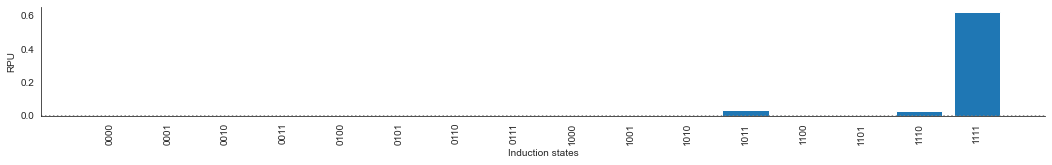

In [257]:
c = candidates[0][2]
plt.figure(figsize=[18, 2])
plt.bar(np.arange(16), c)
plt.axhline(0, linestyle='dotted', color='gray')
plt.ylabel('RPU')
plt.xlabel('Induction states')
#plt.yscale('log')
plt.xticks(np.arange(16), [format(x, "04b") for x in np.arange(16)], rotation=90)
#plt.xticklabels(np.arange(64), rotation=90)
print(c[-1], np.max(c[:-1]), c[-1]/np.max(c[:-1]))
sns.despine()

In [213]:
print(candidates[0][2][-1], np.max(candidates[0][2][:-1]), np.log(candidates[0][2][-1]/np.max(candidates[0][2][:-1])))

4.844287320028459e-13 4.50650458995985e-13 0.07227832102000707


In [238]:
[gates[i] for i in candidates[0][0]]

['e16x33NrdA2', 'e20x32gp411', 'e11x32STPhoRadA']

0.0003761150810511654 0.0003530661536796374 0.06323971961956748


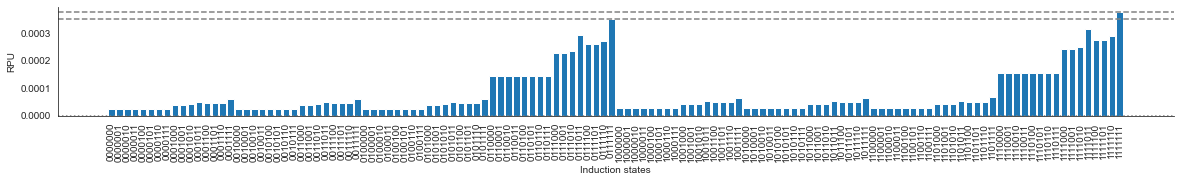

In [206]:
c = candidates[0][2][-128:]
plt.figure(figsize=[20, 2])
plt.bar(np.arange(128), c)
plt.axhline(0, linestyle='dotted', color='gray')
plt.ylabel('RPU')
plt.xlabel('Induction states')
#plt.yscale('log')
plt.xticks(np.arange(128), [format(x, "07b") for x in np.arange(128)], rotation=90)
plt.axhline(np.max(c[:-1]), linestyle='--', color='gray')
plt.axhline(c[-1], linestyle='--', color='gray')
#plt.xticklabels(np.arange(64), rotation=90)
print(candidates[0][2][-1], np.max(candidates[0][2][:-1]), np.log(candidates[0][2][-1]/np.max(candidates[0][2][:-1])))
sns.despine()

4.844287320028459e-13 4.50650458995985e-13 0.07227832102000707


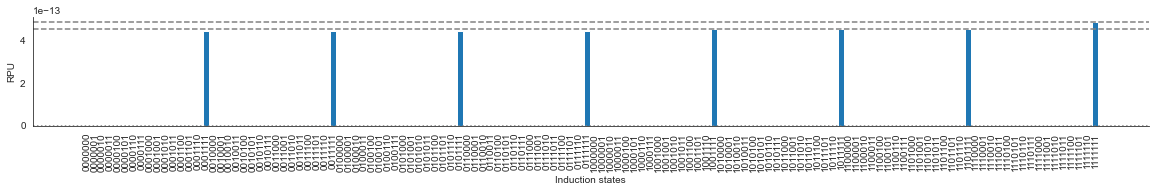

In [215]:
c = candidates[0][2][-128:]
plt.figure(figsize=[20, 2])
plt.bar(np.arange(128), c)
plt.axhline(0, linestyle='dotted', color='gray')
plt.ylabel('RPU')
plt.xlabel('Induction states')
#plt.yscale('log')
plt.xticks(np.arange(128), [format(x, "07b") for x in np.arange(128)], rotation=90)
plt.axhline(np.max(c[:-1]), linestyle='--', color='gray')
plt.axhline(c[-1], linestyle='--', color='gray')
#plt.xticklabels(np.arange(64), rotation=90)
print(candidates[0][2][-1], np.max(candidates[0][2][:-1]), np.log(candidates[0][2][-1]/np.max(candidates[0][2][:-1])))
sns.despine()

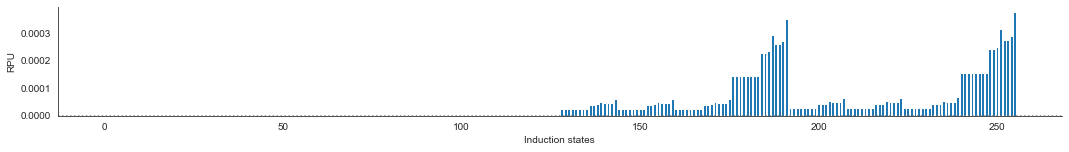

In [200]:
c = candidates[0][2]
plt.figure(figsize=[18, 2])
plt.bar(np.arange(256), c)
plt.axhline(0, linestyle='dotted', color='gray')
plt.ylabel('RPU')
plt.xlabel('Induction states')
#plt.yscale('log')
#plt.xticks(np.arange(256), [format(x, "08b") for x in np.arange(256)], rotation=90)
#plt.xticklabels(np.arange(64), rotation=90)
#print(candidates[0][2][-1], np.max(candidates[0][2][:-1]), np.log(candidates[0][2][-1]/np.max(candidates[0][2][:-1])))
#plt.ylim([0, 0.0004])
sns.despine()

### 2nd Optimization

In [304]:
class GeneticAlgorithm2:

    def __init__(self, gates, inducers, hill_params, num_selection, population_size=100, elite_size=0.1, generations=30, mutation_rate=0.02):
        
        self.gates = gates
        self.inducers = inducers
        self.hill_params = hill_params
        self.num_selection = num_selection
        self.population_size = population_size
        self.num_elite = int(elite_size * population_size)
        self.generations = generations
        self.mutation_rate = mutation_rate
        
        self.best_populations = []
        
    def circuit_designer_4(self, gates):

        return {
            'name': 'circuit1',
            'sensors': ['sensor_{}'.format(i) for i in range(4)], #--> sensor name does not really matter
            'gates': [
                'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
                'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
                'AND({},{},{})'.format(gates[2], gates[0], gates[1])
            ]
        }
    
    def circuit_designer_8(self, gates):
         return {
            'name': 'circuit2',
            'sensors': ['sensor_{}'.format(i) for i in range(8)],
            'gates': [
                'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
                'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
                'AND({},{},{})'.format(gates[2], 'sensor_4', 'sensor_5'),
                'AND({},{},{})'.format(gates[3], 'sensor_6', 'sensor_7'),
                'AND({},{},{})'.format(gates[4], gates[0], gates[1]),
                'AND({},{},{})'.format(gates[5], gates[2], gates[3]),
                'AND({},{},{})'.format(gates[6], gates[4], gates[5])
            ]
         }
        
    def create_population(self):
    
        return [[np.random.uniform(0, 15) for _ in range(len(self.inducers))]
                for _ in range(self.population_size)] #repeated arrangement is allowed

    def calculate_fitness(self, population):

        fitness = []
        num_inputs = self.num_selection + 1
        input_states = [format(x, '0{}b'.format(num_inputs)) for x in list(range(2**num_inputs))]
        
        for indiv in population:
            
            outputs = []
            
            if num_inputs==4:
                circuit_design = self.circuit_designer_4([self.gates[i] for i in [4, 6, 1, 8, 2, 3, 0]])
            elif num_inputs==8:
                circuit_design = self.circuit_designer_8([self.gates[i] for i in [4, 6, 1, 8, 2, 3, 0]])

            for input_state in input_states:        
                induction_lvl = [inducer*int(j) for inducer, j in zip(indiv, input_state)]
                circuit = Circuit(circuit_design, induction_lvl, self.hill_params)
                circuit.signal_match()
                outputs.append(circuit.get_output())

            on = outputs[-1] #on state is always the last state
            max_off = np.max(outputs[:-1])
            dyn_range = np.log(on/max_off) if max_off!=0 else np.log(on/1e-50) #random denominator to avoid division with zero
            fitness.append(dyn_range)

        return fitness

    def rank_population(self, population):

        fitness = self.calculate_fitness(population)
        return sorted([(a, b) for a, b in zip(population, fitness)], key=lambda x: x[1], reverse=True)
    
    def selection(self, sorted_pop):

        #might need to define another selection method later
        selected_pop = []
        df = pd.DataFrame(sorted_pop, columns=['index', 'fitness'])
        df['cum_sum'] = df['fitness'].cumsum()
        df['cum_perc'] = 100 * df['cum_sum'] / df['fitness'].sum()

        for i in range(self.num_elite): #ellitists
            selected_pop.append(sorted_pop[i][0])

        for i in range(len(sorted_pop) - self.num_elite): #remainings
            pick = 100 * random.random()
            for i in range(len(sorted_pop)):
                if pick <= df.iat[i, 3]:
                    selected_pop.append(sorted_pop[i][0])
                    break

        return selected_pop
    
    def mating_pool(self, population):
    
        return [selected for selected in population] #might need some fixing?
    
    def crossover(parent1, parent2):

        child_p1 = []
        child_p2 = []
        gene_A = int(random.random() * len(parent1))
        gene_B = int(random.random() * len(parent1))
        start_gene = min(gene_A, gene_B)
        end_gene = max(gene_A, gene_B)
        child_p1 = [parent1[i] for i in range(start_gene, end_gene)]    
        child_p2 = [item for item in parent2 if item not in child_p1]
        child = child_p1 + child_p2

        return child

    def crossover_population(self, mating_pop):

        children = []
        non_elite = len(mating_pop) - self.num_elite
        pool = random.choices(mating_pop, k=len(mating_pop))

        for i in range(self.num_elite):
            children.append(mating_pop[i])

        for i in range(non_elite):
            child = crossover(pool[i], pool[len(mating_pop)-i-1])
            children.append(child[:self.num_selection])

        return children
    
    def mutate(self, individual):

        for swapped in range(len(individual)):
            if(random.random() < self.mutation_rate):
                swapwith = int(random.random() * len(individual))
                temp = individual[swapped]
                individual[swapped] = individual[swapwith]
                individual[swapwith] = temp
        return individual

    def mutate_population(self, population):
    
        return [self.mutate(indiv) for indiv in population]
    
    def next_generation(self, current_pop):
    
        ranked_pop = self.rank_population(current_pop)
        selected_pop = self.selection(ranked_pop)
        mating_pop = self.mating_pool(selected_pop)
        children = self.crossover_population(mating_pop)
        next_pop = self.mutate_population(children)
        return next_pop
    
    def best_individuals(self, num_indiv=1):
        
        return self.best_populations[:num_indiv]

    def run(self):

        pop = self.create_population()
        #init_pop = pop.copy()
        for i in range(self.generations):
            population = self.next_generation(pop)
        
        self.best_populations = self.rank_population(pop)

In [305]:
pops = [50, 100, 200, 500]
gens = [10, 50, 100]
muts = [0.02, 0.1, 0.2]

results = []
for p in tqdm(pops):
    for g in gens:
        for m in muts:
            ga2 = GeneticAlgorithm2(gates, inducers, hill_params, 7,
                                  population_size=p,
                                  elite_size=0.2,
                                  generations=g,
                                  mutation_rate=m
                                 )
            ga2.run()
            best_fit = ga2.best_individuals(1)[0][1]
            config = p, g, m
            results.append((config, best_fit))

100%|██████████| 4/4 [1:33:37<00:00, 1404.47s/it]


In [312]:
df = pd.DataFrame(results, columns=['index', ('fitness')])
df['population'] = df['index'].apply(lambda x: x[0])
df['generation'] = df['index'].apply(lambda x: x[1])
df['mutation'] = df['index'].apply(lambda x: x[2])
df

,index,fitness,population,generation,mutation
0,"(50, 10, 0.02)",0.539073,50,10,0.02
1,"(50, 10, 0.1)",0.290027,50,10,0.10
2,"(50, 10, 0.2)",0.165557,50,10,0.20
3,"(50, 50, 0.02)",0.051415,50,50,0.02
4,"(50, 50, 0.1)",0.598604,50,50,0.10
5,"(50, 50, 0.2)",0.051529,50,50,0.20
6,"(50, 100, 0.02)",0.093594,50,100,0.02
7,"(50, 100, 0.1)",0.113095,50,100,0.10
8,"(50, 100, 0.2)",0.199122,50,100,0.20
9,"(100, 10, 0.02)",0.349405,100,10,0.02


In [313]:
df[df['population']==50]['fitness']

,index,fitness,population,generation,mutation
0,"(50, 10, 0.02)",0.539073,50,10,0.02
1,"(50, 10, 0.1)",0.290027,50,10,0.10
2,"(50, 10, 0.2)",0.165557,50,10,0.20
3,"(50, 50, 0.02)",0.051415,50,50,0.02
4,"(50, 50, 0.1)",0.598604,50,50,0.10
5,"(50, 50, 0.2)",0.051529,50,50,0.20
6,"(50, 100, 0.02)",0.093594,50,100,0.02
7,"(50, 100, 0.1)",0.113095,50,100,0.10
8,"(50, 100, 0.2)",0.199122,50,100,0.20


In [298]:
best23[0]

([5.5724755222094045,
  11.327400394104007,
  4.44516062682043,
  0.6981289236941518,
  7.01936182967039,
  12.110248901588538,
  4.771771695004084,
  4.48234796453721],
 0.5264610917543655)

In [293]:
def circuit_designer_4(gates):
    return {
        'name': 'circuit1',
        'sensors': ['sensor_{}'.format(i) for i in range(4)], #--> sensor name does not really matter
        'gates': [
            'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
            'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
            'AND({},{},{})'.format(gates[2], gates[0], gates[1])
        ]
    }

def circuit_designer_8(gates):
     return {
        'name': 'circuit2',
        'sensors': ['sensor_{}'.format(i) for i in range(8)],
        'gates': [
            'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
            'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
            'AND({},{},{})'.format(gates[2], 'sensor_4', 'sensor_5'),
            'AND({},{},{})'.format(gates[3], 'sensor_6', 'sensor_7'),
            'AND({},{},{})'.format(gates[4], gates[0], gates[1]),
            'AND({},{},{})'.format(gates[5], gates[2], gates[3]),
            'AND({},{},{})'.format(gates[6], gates[4], gates[5])
        ]
     }
    
def calculate_fitness(population):

    profile = []
    arrangement = [x[0] for x in population]
    num_inputs = 8
    input_states = [format(x, '0{}b'.format(num_inputs)) for x in list(range(2**num_inputs))]

    for indiv in arrangement:

        outputs = []
        if num_inputs==4:
            circuit_design = circuit_designer_4([gates[i] for i in [4, 6, 1, 8, 2, 3, 0]])
        elif num_inputs==8:
            circuit_design = circuit_designer_8([gates[i] for i in [4, 6, 1, 8, 2, 3, 0]])

        for input_state in input_states:          
            induction_lvl = [inducer*int(j) for inducer, j in zip(indiv, input_state)]
            circuit = Circuit(circuit_design, induction_lvl, hill_params)
            circuit.signal_match()
            outputs.append(circuit.get_output())

        on = outputs[-1] #on state is always the last state
        max_off = np.max(outputs[:-1])
        dyn_range = np.log(on/max_off) if max_off!=0 else np.log(on/1e-50) #random denominator to avoid division with zero
        profile.append((indiv, dyn_range, outputs))

    return profile

candidates = calculate_fitness(best23)

0.15223320086995146 0.08992288499359594 0.5264610917543655


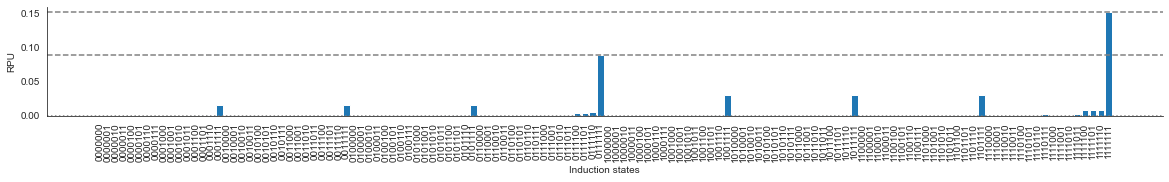

In [294]:
c = candidates[0][2][-128:]
plt.figure(figsize=[20, 2])
plt.bar(np.arange(128), c)
plt.axhline(0, linestyle='dotted', color='gray')
plt.ylabel('RPU')
plt.xlabel('Induction states')
#plt.yscale('log')
plt.xticks(np.arange(128), [format(x, "07b") for x in np.arange(128)], rotation=90)
plt.axhline(np.max(c[:-1]), linestyle='--', color='gray')
plt.axhline(c[-1], linestyle='--', color='gray')
#plt.xticklabels(np.arange(64), rotation=90)
print(candidates[0][2][-1], np.max(candidates[0][2][:-1]), np.log(candidates[0][2][-1]/np.max(candidates[0][2][:-1])))
sns.despine()

In [295]:
candidates[0][0]a

[5.5724755222094045,
 11.327400394104007,
 4.44516062682043,
 0.6981289236941518,
 7.01936182967039,
 12.110248901588538,
 4.771771695004084,
 4.48234796453721]

0.08763102729127745 0.046949137213671686 0.6240702992738676


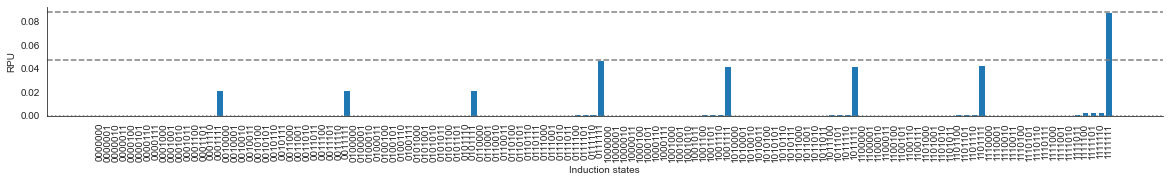

In [289]:
c = candidates[0][2][-128:]
plt.figure(figsize=[20, 2])
plt.bar(np.arange(128), c)
plt.axhline(0, linestyle='dotted', color='gray')
plt.ylabel('RPU')
plt.xlabel('Induction states')
#plt.yscale('log')
plt.xticks(np.arange(128), [format(x, "07b") for x in np.arange(128)], rotation=90)
plt.axhline(np.max(c[:-1]), linestyle='--', color='gray')
plt.axhline(c[-1], linestyle='--', color='gray')
#plt.xticklabels(np.arange(64), rotation=90)
print(candidates[0][2][-1], np.max(candidates[0][2][:-1]), np.log(candidates[0][2][-1]/np.max(candidates[0][2][:-1])))
sns.despine()

In [290]:
candidates[0][0]

[1.0814948426509856,
 8.044990611802286,
 0.05560704856466305,
 0.41640634192892123,
 0.5220204521939621,
 6.752613304849315,
 0.1725777559052178,
 6.472965853079174]